# Pipelining: chaining a PCA and a logistic regression
- PCA는 비지도 차원 축소를 수행하고, 로지스틱 회귀는 예측을 수행

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
# PCA truncation와 분류기 정규화의 최적 조합을 검색하는 파이프라인 정의
pca = PCA()
# 표준 스케일러를 정의하여 입력을 정규화
scaler = StandardScaler()

# 허용 오차를 큰 값으로 설정하여 예제를 더 빠르게 만듦
logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("logistic", logistic)])

X_digits, y_digits = datasets.load_digits(return_X_y=True)
# 파이프인의 매개변수는 '__'로 구분된 매개변수 이름을 사용하여 설정
param_grid = {
    "pca__n_components": [5, 15, 30, 45, 60],
    "logistic__C": np.logspace(-4, 4, 4),
}
search = GridSearchCV(pipe, param_grid, n_jobs=2)
search.fit(X_digits, y_digits)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# PCA 스펙트럼 플롯
pca.fit(X_digits)

Best parameter (CV score=0.924):
{'logistic__C': 0.046415888336127774, 'pca__n_components': 60}


PCA()

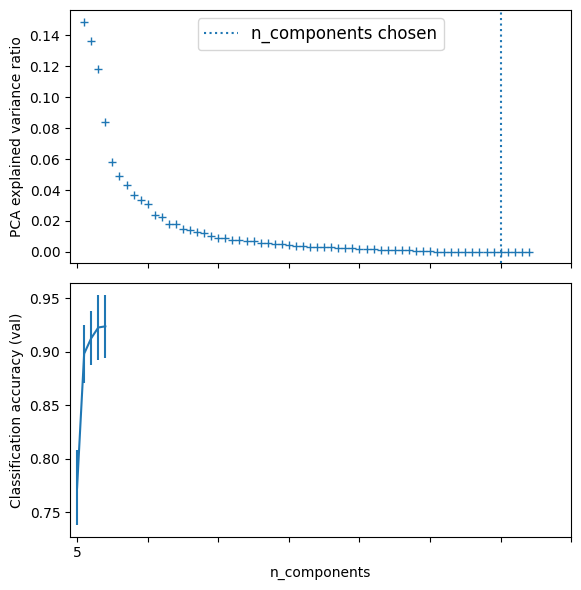

In [3]:
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(
    np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, "+", linewidth=2
)
ax0.set_ylabel("PCA explained variance ratio")

ax0.axvline(
    search.best_estimator_.named_steps["pca"].n_components,
    linestyle=":",
    label="n_components chosen",
)
ax0.legend(prop=dict(size=12))

# 각 구성 요소 수에 대해 최상의 분류기 결과를 찾기
results = pd.DataFrame(search.cv_results_)
components_col = "param_pca__n_components"
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, "mean_test_score")
)

best_clfs.plot(
    x=components_col, y="mean_test_score", yerr="std_test_score", legend=False, ax=ax1
)
ax1.set_ylabel("Classification accuracy (val)")
ax1.set_xlabel("n_components")

plt.xlim(-1, 70)

plt.tight_layout()
plt.show()